# Contents
- [Setup](#Setup)
- [11.2 Allowed Rotations](#11.2-Allowed-Rotations)
    - [Calculations for Figures 11.1 - 12.1](#Calculations-for-Figures-11.1---12.1)
    - [Figure 11.1](#Figure-11.1)
    - [Figure 11.2](#Figure-11.2)
- [12.1 1/f Noise](#12.1-1/f-Noise)
    - [Calculation for Figure 12.1](#Calculation-for-Figure-12.1)
    - [Figure 11.2](#Figure-12.1)
- [Figures 12.2 – 14.3](#Figures-12.2-–-14.3)
    - [Parallel Processing](#Parallel-Processing)
    - [Example RB Run](#Example-RB-Run)
    - [Accumulating Infidelities](#Accumulating-Infidelities)

# Setup

In [1]:
using Plots
gr(dpi=150,linewidth=2,size=(350,200),markerstrokecolor=:auto,palette=RGB.([0x4c599a, 0xe66c6c, 0x7bc572, 0xfda440, 0x55bad8, 0xe467a8, 0x6ba2d8, 0xc87fcd, 0x448b26, 0x565559]),
background_color_legend=nothing,foreground_color_legend=nothing)
import DataFrames.DataFrame, DataStructures.OrderedDict
include("tqd/tqd.jl");

# 11.2 Allowed Rotations
## Calculations for Figures 11.1 - 12.1

In [2]:
params = [
    :U  => 10,
    :V  => 3,
    :ε  => 0,
    :εₘ => -3,
    :t  => 0.05,
    :δ  => 0.05
];

tₗ,tᵣ,τ,gates = zeros(0),zeros(0),zeros(0),Int[]
for gate ∈ [10,17]
    tₗₖ,tᵣₖ,τₖ = tqdpulseC(gate+1,0;params...)
    push!(τ,-10)
    push!(tₗ,0)
    push!(tᵣ,0)
    push!(τ,0)
    push!(tₗ,0)
    push!(tᵣ,0)
    for k ∈ 1:length(τₖ)
        τ₀  = k == 1 ? 0 : τₖ[k-1]
        push!(τ,τ₀)
        push!(tₗ,tₗₖ[k])
        push!(tᵣ,tᵣₖ[k])
        push!(τ,τₖ[k])
        push!(tₗ,tₗₖ[k])
        push!(tᵣ,tᵣₖ[k])
    end
    push!(τ,τₖ[end])
    push!(tₗ,0)
    push!(tᵣ,0)
    push!(τ,10)
    push!(tₗ,0)
    push!(tᵣ,0)
    append!(gates,fill(gate,4+2length(τₖ)))
end
println("Calculation finished.")


Calculation finished.


## Figure 11.1
$H$ pulse sequence

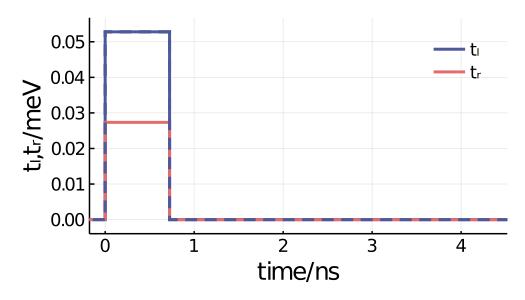

In [3]:
gᵢ = gates .== 10
τₑ = extrema(τ[abs.(τ).!=10])
Δτ = τₑ[2]-τₑ[1]
τlims = (τₑ.+Δτ*[-0.01,0.01])
tₑ = extrema([tₗ;tᵣ])
Δt = tₑ[2]-tₑ[1]
tlims = extrema(tₑ.+Δt*[-0.075,0.075])
plot(xlims=τlims,ylims=tlims,ylabel="tₗ,tᵣ/meV",xlabel="time/ns")
plot!(τ[gᵢ],tₗ[gᵢ],label="tₗ",c=1)
plot!(τ[gᵢ],tᵣ[gᵢ],label="tᵣ",c=2)
plot!(τ[gᵢ],tₗ[gᵢ],label=false,c=1,linestyle=:dash)

## Figure 11.2
$C_{17}$ pulse sequence

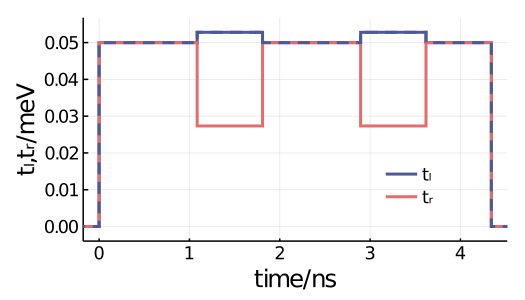

In [4]:
gᵢ = gates .== 17
plot(xlims=τlims,ylims=tlims,legend=legend=(.8,.3),ylabel="tₗ,tᵣ/meV",xlabel="time/ns")
plot!(τ[gᵢ],tₗ[gᵢ],label="tₗ",c=1)
plot!(τ[gᵢ],tᵣ[gᵢ],label="tᵣ",c=2)
plot!(τ[gᵢ],tₗ[gᵢ],label=false,c=1,linestyle=:dash)

# 12.1 1/f Noise
## Calculation for Figure 12.1

In [5]:
tₙₗ,tₙᵣ,εₙ,εₙₘ,τₙ = tqdnoiseypulseseq([17+1];params...);

Nₙ  = length(εₙ)
Hzₙ = (Nₙ-1)/(τₙ[end]-τₙ[1])
fₙ  = collect(rfftfreq(Nₙ,Hzₙ))
fₙ[fₙ .< fₙ[2]] .= fₙ[2]
fεₙ = rfft(εₙ)
fεₙₘ = rfft(εₙₘ)
ftₙₗ = rfft(tₙₗ)
ftₙᵣ = rfft(tₙᵣ)

Sεₙ  = abs2.(fεₙ)
Sεₙₘ = abs2.(fεₙₘ)
Stₙₗ = abs2.(ftₙₗ)
Stₙᵣ = abs2.(ftₙᵣ)

println("Calculation finished.")

Calculation finished.


## Figure 12.1
The amplitude (top two, bottom right) and spectrum (bottom left) plots
for all four parameters involved in the execution of $C_{17}$, with noise introduced. The
dotted lines in the amplitude plots of $\varepsilon$ and $\varepsilon_m$ mark $\pm 5\%$ of the target amplitude,
while the dotted line in the spectrum plot marks $S \propto 1/f$.

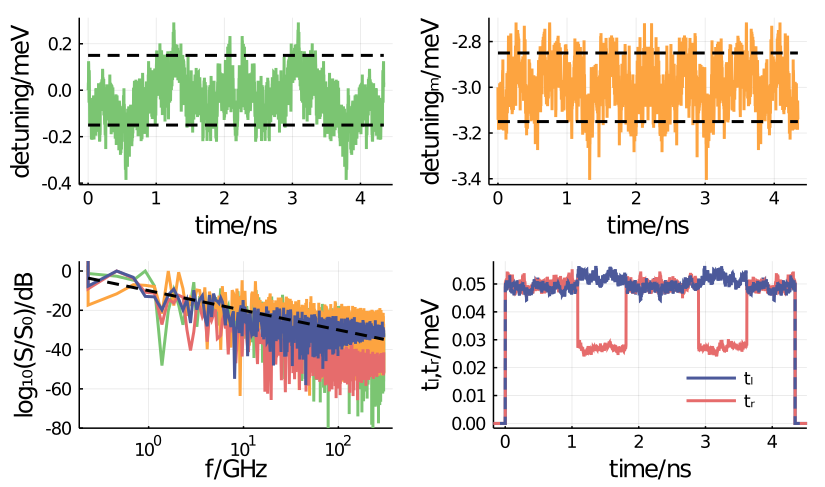

In [6]:
plt1 = plot(ylab="detuning/meV",xlab="time/ns")
plot!(plt1,τₙ,εₙ,colour=3,label=false)
plot!(plt1,[τₙ[1],τₙ[end]],[1.5e-1,1.5e-1],label=false,colour="black",linestyle=:dash)
plot!(plt1,[τₙ[1],τₙ[end]],[-1.5e-1,-1.5e-1],label=false,colour="black",linestyle=:dash)

plt2 = plot(ylab="detuningₘ/meV",xlab="time/ns")
plot!(plt2,τₙ,εₙₘ,colour=4,label=false)
plot!(plt2,[τₙ[1],τₙ[end]],-3 .+ [1.5e-1,1.5e-1],label=false,colour="black",linestyle=:dash)
plot!(plt2,[τₙ[1],τₙ[end]],-3 .+ [-1.5e-1,-1.5e-1],label=false,colour="black",linestyle=:dash)


plt3 = plot(ylabel="log₁₀(S/S₀)/dB",xlabel="f/GHz",xticks=([1,10,100]),ylims=(-80,5),xscale=:log10,legend=false
)
plot!(plt3,fₙ,10log10.(Sεₙ/maximum(Sεₙ[2:end])),colour=3)
plot!(plt3,fₙ,10log10.(Sεₙₘ/maximum(Sεₙₘ[2:end])),colour=4)
plot!(plt3,fₙ,10log10.(Stₙᵣ/maximum(Stₙᵣ[2:end])),colour=2)
plot!(plt3,fₙ,10log10.(Stₙₗ/maximum(Stₙₗ[2:end])),colour=1)
plot!(plt3,fₙ,-10*log10.(fₙ) .- 10,colour="black",linestyle=:dash)

plt4 = plot(xlims=τlims,ylab="tₗ,tᵣ/meV",xlab="time/ns",legend=(.8,.3))
plot!(plt4,[-10;τₙ;τₙ[end];10],[0;tₙₗ;0;0],label="tₗ")
plot!(plt4,[-10;τₙ;τₙ[end];10],[0;tₙᵣ;0;0],label="tᵣ")
plot!(plt4,[-10;τₙ;τₙ[end];10],[0;tₙₗ;0;0],label=false,colour=1,linestyle=:dash)


plot(plt1,plt2,plt3,plt4,size=(550,325))

# Figures 12.2 – 14.3

The rest of the figures consists of multiple RB experiments, which are too computationally expensive to run on a notebook. Rather, it should be downloaded and run locally, preferablly with multiprocessing (`mpirun`) support.

The main executable here is ``executeRB.jl`` in the folder ``tqd``. That directory should also have a folder called `params` and one called `data`. `params` contain `*.json` files that define the parameters for each experiment. They are of the form
```json
{
    "dir": "data/sweetSpot",
    "K": 500,
    "M": {"start":1,"stop":101,"step":2},
    "U": 10,
    "V": 3,
    "ε": {"start":-1.0,"stop":1.0,"step":0.5},
    "εₘ": {"start":-4.0,"stop":-2.0,"step":0.5},
    "t": 0.05,
    "δ": 0.01,
    "δε": 3.0,
    "δt": 0.0
}
```

The parameters are named exactly like in the thesis, so they should be self-explainatory. The only change is
the addition of $\delta$, which is a convenient way of adjusting the error in all parameters. For $\varepsilon,\varepsilon_m,t_l$, and $t_r$, the noise produced is, for example with $t_l$,

$$
\tilde{t}_l(\tau) = t_l + \delta \times \delta t_l \times f(\tau)
$$

where $f(\tau)$ is the $1/f$ noise spectrum normalised so that $\operatorname{RMS}[f(\tau)] = \sqrt{2}$. $\delta t_l$ is set to

- $\delta t_l$ if it is provided, so assigning $\delta t_l$ in the parameters overrides all other settings, if not;
- $\delta t$ if it is provided, a convenient way of assigning the noise for both tunneling parameters, if not;
- $t$ if neither of the above are provided, which is the default behaviour of $\tilde{t}_l(\tau)$ having a noise spectrum that fluctuates $\pm \delta$ of $t_l$

The exact parameters used to create the data in the thesis are

|Figure|<div style="text-align:center">Caption</div>|Parameters File|
|-----------------|:------|:------------------------------------|
| **12.2** | An RB experiment in the presence of noise. With very noisy gates, it is difficult to get a proper fit — in the worse case for each plot shown here, the fidelity decays to the minimum value within one or two gates. | [fitting.json](tqd/params/fitting.json) for $\delta t_{l/r} = 5\%$,<br> other values from Figures 13.5 & 13.6 |
| **13.3** | $r$ against noise. The filled and unfilled points are the fitted and eigenvalue $r$ respectively, while the solid line is the actual average gate infidelity, with the dashed lines indicating its standard deviation.| 1. [infidelity/euler/δε0_δt0.12.json](tqd/params/infidelity/euler/δε0_δt0.12.json)<br>2. [infidelity/euler/δε0.45_δt0.09.json](tqd/params/infidelity/euler/δε0.45_δt0.09.json)<br>3. [infidelity/euler/δε0.45_δt0.09.json](tqd/params/infidelity/euler/δε0.45_δt0.09.json)|
| **13.2** | $r$ around the sweet spot, with all noise at 1% amplitude. The sweet spot is dead centre, with $\varepsilon = 0$, $\varepsilon_m = -3\mathrm{meV}$ | [sweetSpot/δε0.01_δt0.01.json](tqd/params/sweetSpot/δε0.01_δt0.01.json) |
| **13.3** | $\delta\varepsilon, \delta\varepsilon_m = 1\%$, $\delta t_l,\delta t_r = 0$. Sweet spot behaviour is clearer in the absence of $\delta t_l,\delta t_r$| [sweetSpot/δε0.01_δt0.json](tqd/params/sweetSpot/δε0.01_δt0.json) |
| **13.4** | $\delta t_l,\delta t_r = 0.5\%$, $\delta\varepsilon, \delta\varepsilon_m = 0$. With only tunnelling noise, no pattern to average gate infidelity | [sweetSpot/δε0_δt0.005.json](tqd/params/sweetSpot/δε0_δt0.005.json) |
| **13.5** | $r$ against $\delta\varepsilon,\delta\varepsilon_m$, with $\delta t_l = \delta t_r = 0$. Each cell is an RB experiment. | [sensitivity/δεδεₘ.json](tqd/params/sensitivity/δεδεₘ.json) |
| **13.6** | $r$ against $\delta t_l,\delta t_r$, with $\delta\varepsilon = \delta\varepsilon_m=0$. Each cell is an RB experiment. | [sensitivity/δtₗδtᵣ.json](tqd/params/sensitivity/δtₗδtᵣ.json) |
| **14.2** | RB numbers of improved pulse sequence, using the same parameters of and underlaid with Figure 13.1. | 1. [infidelity/improved/δε0_δt0.12.json](tqd/params/infidelity/improved/δε0_δt0.12.json)<br>2. [infidelity/improved/δε0.45_δt0.09.json](tqd/params/infidelity/improved/δε0.45_δt0.09.json)<br>3. [infidelity/improved/δε0.45_δt0.09.json](tqd/params/infidelity/improved/δε0.45_δt0.09.json) |
| **14.2** | The distribution of $r$ around the sweet spot (see Figures 13.2—13.4). Positively skewed when detuning noise dominates, and should approach 0 skewness (uniform/normal randomness) when tunnelling noise dominates. | Boxplot and skew of Figures 13.2 – 13.4 |

and the command to run it is

```sh
julia executeRB.jl {param.json}

```

## Parallel Processing
Each run takes a rather long time (from half a day to two days), so it might not be a good idea to run it on the notebook. The code has been programmed to work with MPI, so doing

```sh
mpirun -n {no. of processors} julia executeRB.jl {param.json}
```

is recommended.


## Example RB Run

Below is an example of how one (short) run would go. This sample has very small repetition $K$, so the uncertainty will be very high. It just serves as an example on its workings.

**<span style="color:#e66c6c;font-size:150\%">Note that it takes about 1~2 minutes to run each point, and there are six points in total, so this will take about <u>10 minutes</u> depending on the server's speed. [params/sample.json](/edit/tqd/params/sample.json) can be edited to reduce the number of parameters.</span>**

In [7]:
# This should run in the 'tqd' directory
cd("tqd");
run(`julia executeRB.jl params/sample.json`);
cd("..");

Rank 0 started δt = 0.025, δε = 0 on 2020-04-26T19:25:31.086
Rank 0 took 61.821309 seconds (216.09 M allocations: 20.510 GiB, 8.20% gc time)
Parameters 1 of 6 finished
Rank 0 started δt = 0.035, δε = 0 on 2020-04-26T19:26:44.384
Rank 0 took 40.903232 seconds (174.52 M allocations: 18.553 GiB, 8.13% gc time)
Parameters 2 of 6 finished
Rank 0 started δt = 0.055, δε = 0 on 2020-04-26T19:27:25.428
Rank 0 took 40.005095 seconds (173.33 M allocations: 18.523 GiB, 9.37% gc time)
Parameters 3 of 6 finished
Rank 0 started δt = 0.025, δε = 3 on 2020-04-26T19:28:05.435
Rank 0 took 39.965059 seconds (174.14 M allocations: 18.603 GiB, 9.64% gc time)
Parameters 4 of 6 finished
Rank 0 started δt = 0.035, δε = 3 on 2020-04-26T19:28:45.401
Rank 0 took 41.699064 seconds (172.56 M allocations: 18.421 GiB, 9.16% gc time)
Parameters 5 of 6 finished
Rank 0 started δt = 0.055, δε = 3 on 2020-04-26T19:29:27.102
Rank 0 took 42.516377 seconds (174.61 M allocations: 18.637 GiB, 8.59% gc time)
Parameters 6 of 6 f

After having done the run, the data is saved in the folder as specified in the parameter file. In this case, it is in `data/sample`. The data can be read and plotted in any preferred way.

The contents of the output file are

```json
{
    "iF":  [
             [1-F₁₁, 1-F₁₂, …, 1-F₁ₖ], /* Survivial probabilites Fₘₖ, */
             [1-F₂₁, 1-F₂₂, …, 1-F₂ₖ], /* m indexes sequence length,  */
             [  …  ,   …  , …,   …  ], /* k indexes repetition        */
             [1-Fₘ₁, 1-Fₘ₂, …, 1-Fₘₖ]
           ],
    "τ":   [
             [τ₁₁, …, τ₁ₖ], /* Execution time of     */
             [ … , …,  … ], /* each sequence length. */
             [τₘ₁, …, τₘₖ]  /* Indexed as above.     */
           ],
    "iμF": [1-⟨F₁⟩ₖ, 1-⟨F₂⟩ₖ, …, 1-⟨Fₘ⟩ₖ], // Survival probabilities averaged over repetitions
    "σF":  [SEₖ[F₁], SEₖ[F₂], …, SEₖ[Fₘ]], // Standard error of the average
    "p":   [p,A,B],    // Fitted vales of F(m) = Apᵐ+B
    "σp":  [σp,σA,σB], // Margin of error of fit
    "p̄":   [p̄,Ā,B̄],    // Values from eigen equation
    "μr̄":  μr̄, // Actual average infidelity, calculated directly
    "σr̄":  σr̄, // Standard deviation of actual average infidelity
}
```

Here is an example of how it may be plotted:

In [8]:
include("lib/tqdParams.jl")

rbEqn(m,p) = p[2]*p[1].^m .+ p[3]

function doPlot(v,c=1,plt=nothing)
    data,alert = loadparams(vals[v],loopKey,noloopParams)
    if data != false
        μF = 1 .- data["iμF"]
        σF = data["σF"]

        p = data["p"]
        σp = data["σp"]
        p̄ = data["p̄"]

        if plt == nothing
            plt = plot()
        end

        scatter!(plt,M,μF,yerror=σF,c=c,label=false)
        plot!(plt,m->rbEqn(m,p),M[1]:.5:M[end],colour=c,label=false)
        plot!(plt,m->rbEqn(m,p̄),M[1]:.5:M[end],colour=c,label=false,ls=:dash)

        xlabel!(plt,"M")
        ylabel!(plt,"F")
        title!(plt,replace(alert, r"^δ" => "Noise in "))
        return plt, (1-p[1])/2, σp[2]/2, (1-p̄[1])/2, data["μr̄"]
    end
end

doPlot (generic function with 3 methods)

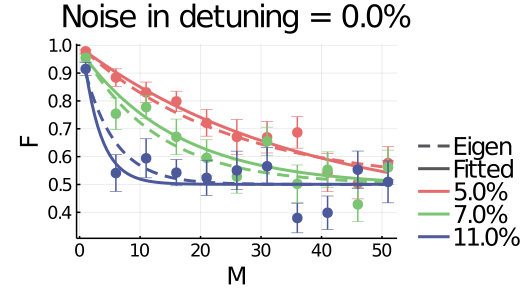

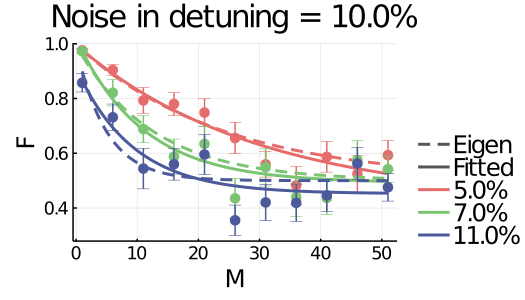

In [9]:
cd("tqd")
params = try
        JSON.parsefile("params/sample.json",dicttype=DataStructures.OrderedDict)
    catch err
        @warn err
    end
dir = try pop!(params, "dir") catch err "" end

M = params["M"] = stepstoarray(params["M"])
loopKey, loopVal, noloopParams = initparams(params)
vals = collect(Iterators.product(loopVal...))

rarr  = zeros(size(vals))
σrarr  = zeros(size(vals))
r̄arr  = zeros(size(vals))
r̄₀arr = zeros(size(vals))
plt = plot()
plot!(plt,[Inf],linestyle=:dash,colour=0,label="Eigen")
plot!(plt,[Inf],colour=0,label="Fitted")
for i in 1:length(vals)
    global plt
    plt,rarr[i],σrarr[i],r̄arr[i],r̄₀arr[i] = doPlot(i,i%size(vals)[1]+1,plt)
    label = round(vals[i][1]/abs(noloopParams["t"])*noloopParams["δ"]*100,sigdigits=3)
    plot!(plt,[Inf],colour=i%size(vals)[1]+1,label="$label%")
    if i%size(vals)[1] == 0
        title = round(vals[i][2]/abs(noloopParams["εₘ"])*noloopParams["δ"]*100,sigdigits=3)
        display(plot(plt,legend=:outerright,title="Noise in detuning = $title%"))
        plt = plot()
        plot!(plt,[Inf],linestyle=:dash,colour=0,label="Eigen")
        plot!(plt,[Inf],colour=0,label="Fitted")
    end
end
cd("..")


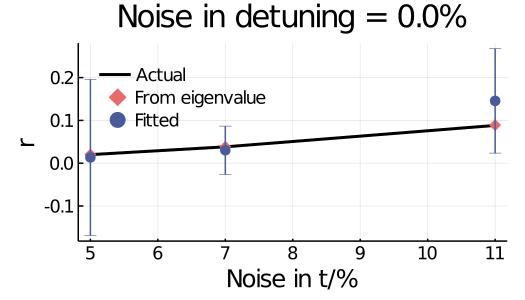

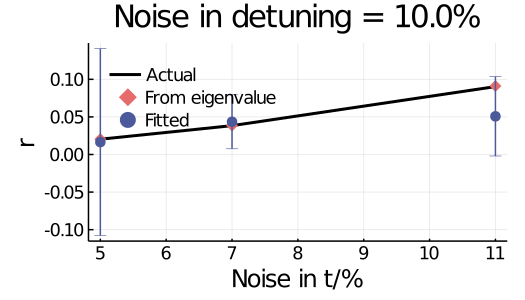

In [10]:
for j ∈ 1:size(vals)[2]
    δε = abs(vals[1,j][2]/noloopParams["εₘ"]*noloopParams["δ"]*100)
    δt = [vals[i,j][1] for i ∈ 1:size(vals)[1]]/noloopParams["t"]*noloopParams["δ"]*100
    plot(δt,r̄₀arr[:,j],label="Actual",colour="black",ylabel="r",xlabel="Noise in t/%",legend=:topleft)
    scatter!(δt,r̄arr[:,j],label="From eigenvalue",colour=2,markershape=:diamond)
    scatter!(δt,rarr[:,j],yerr=σrarr[:,j],label="Fitted",colour=1)
    display(title!("Noise in detuning = $(round(δε,sigdigits=3))%"))
end

## Accumulating Infidelities

In addition, a helper script `accumulateData.jl` is provided, that accumulates the infidelities of a full run
into a single CSV file. This is helpful when working with many RB experiments, especially when looking at how $r$ changes with certain parameters. To use this, run
```sh
julia accumulateData.jl {param.json}
```

In [11]:
# This accumulates the data
cd("tqd")
run(`julia accumulateData.jl params/sample.json`)
cd("..")

# This is just to print it out
data = nothing
dataKeys = nothing
open("tqd/data/sample/sample.accumulated.csv") do f
    global data,dataKeys
    for ln in eachline(f)
        if data == nothing
            dataKeys = split(ln,",")
            data = OrderedDict([k => Float64[] for k ∈ dataKeys ])
        else
            dataRow = parse.(Float64, split(ln,","))
            for k ∈ 1:length(dataKeys)
                push!(data[dataKeys[k]],dataRow[k])
            end
        end
    end
end
display(DataFrame(data))


Accumulating δt = 0.025, δε = 0
Accumulating δt = 0.035, δε = 0
Accumulating δt = 0.055, δε = 0
Accumulating δt = 0.025, δε = 3
Accumulating δt = 0.035, δε = 3
Accumulating δt = 0.055, δε = 3


,U,V,ε,εₘ,t,δ,δt,δε,r
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.0,3.0,0.0,-3.0,0.05,0.1,0.025,0.0,0.0135523
2,10.0,3.0,0.0,-3.0,0.05,0.1,0.035,0.0,0.0303369
3,10.0,3.0,0.0,-3.0,0.05,0.1,0.055,0.0,0.145585
4,10.0,3.0,0.0,-3.0,0.05,0.1,0.025,3.0,0.016521
5,10.0,3.0,0.0,-3.0,0.05,0.1,0.035,3.0,0.0435163
6,10.0,3.0,0.0,-3.0,0.05,0.1,0.055,3.0,0.0507665


Accumulated data saved at data/sample/sample.accumulated.csv
